## Setup

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.gridspec as gs
%load_ext autoreload
%autoreload 2

pt.update_plot_defaults()

# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=True, download=False,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',
                                        train=False, download=False,
                                        transform=tensor_flatten)

# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))
    
MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))
    
# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train, shuffle=True, generator=data_generator)
train_sub_dataloader = torch.utils.data.DataLoader(MNIST_train[0:10000], shuffle=True, generator=data_generator)
val_dataloader = torch.utils.data.DataLoader(MNIST_train[-10000:], batch_size=10000, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10000, shuffle=False)

epochs = 1
data_seed = 0
network_seed = 42

# Backprop network

In [73]:
# Create network
network_name = "EIANN_1_hidden_mnist_backprop_relu_SGD_config.yaml"
network_config = ut.read_from_yaml(f'../config/MNIST_templates/{network_name}')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [74]:
# # Load pretrained network
# saved_network_path = f"saved_networks/{network_name}.pickle"
# bp_network.load(saved_network_path)

# pt.plot_batch_accuracy(bp_network, test_dataloader, population=bp_network.H1.E)
# pt.plot_rsm(bp_network,test_dataloader)

Epochs: 100%|██████████| 1/1 [00:30<00:00, 30.31s/it]
/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:206: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:226: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


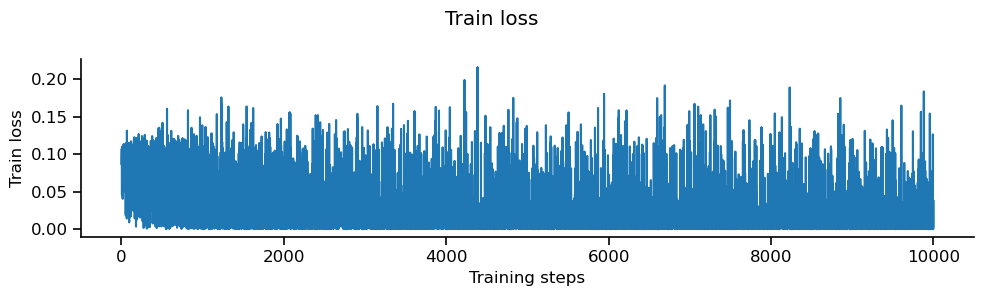

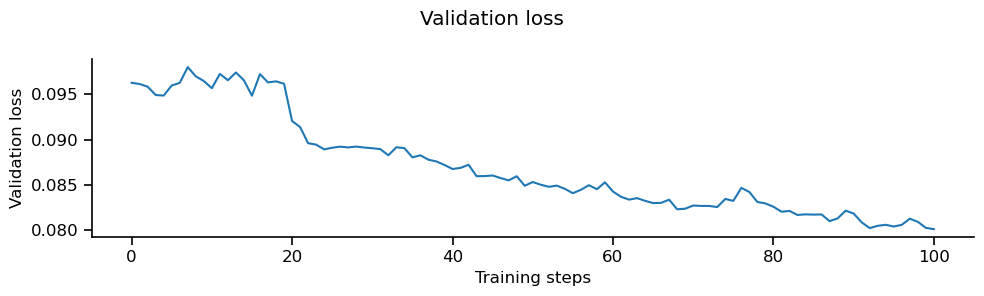

In [75]:
# Train network
data_generator.manual_seed(data_seed)
bp_network.train(train_sub_dataloader, 
                test_dataloader, 
                epochs=epochs,
                val_interval=(0,100,1),
                store_history=True, 
                store_params=True,
                status_bar=True)

# bp_network.save(file_name_base=network_name)

# pt.plot_batch_accuracy(bp_network, test_dataloader, population=bp_network.H1.E)
pt.plot_train_loss_history(bp_network)
pt.plot_validate_loss_history(bp_network)

In [22]:
# Create network
network_name = 'EIANN_1_hidden_mnist_BTSP_config.yaml'
network_config = ut.read_from_yaml(f'../config/MNIST_templates/{network_name}')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

# Train network
data_generator.manual_seed(data_seed)
btsp_network.train(train_sub_dataloader, 
                    test_dataloader, 
                    epochs=epochs,
                    val_interval=(0,10,1),
                    store_history=True, 
                    store_params=True, 
                    status_bar=True)

Epochs: 100%|██████████| 1/1 [01:52<00:00, 112.82s/it]


In [79]:
dataloader = test_dataloader
network = btsp_network

def compute_dW(network, dataloader):
    assert len(dataloader) == 1, 'Dataloader must have a single large batch'
    assert len(network.param_history)>0, 'Network must have param_history'

    # Turn on gradient tracking
    network.backward_steps = 3
    for parameter in network.parameters(): 
        if parameter.is_learned:
            parameter.requires_grad = True

    for i in range(len(network.param_history)-1):
        # Load params into network
        state_dict = network.param_history[i]
        network.load_state_dict(state_dict)
        
        # Compute backprop dW
        idx, data, target = next(iter(dataloader))
        output = network.forward(data)

        network.zero_grad()
        loss = network.criterion(output, target)
        loss.backward()
        gradients = {name: param.grad.flatten() for name, param in network.named_parameters() 
                    if param.requires_grad and param.grad is not None}        

        # Compute BTSP dW (computed dW should be the same as comparing to next params)
        next_state_dict = network.param_history[i+1]
        dW = {}
        for name, param in state_dict.items():
            dW[name] = (next_state_dict[name] - state_dict[name]).flatten()

        break

        # Compute angle between dW's

    return gradients, dW

    '''
    The dot product of two vectors is equal to the product of their magnitudes and the cosine of the angle between them. 
    Therefore, by taking the inverse cosine (arccos) of the dot product divided by the product of the magnitudes of the vectors, 
    the angle between the vectors can be calculated.
    '''

gradients, dW = compute_dW(bp_network, test_dataloader)

In [96]:
bp_network.load_state_dict(bp_network.param_history[0])

idx, data, target = next(iter(test_dataloader))
output = bp_network.forward(data)

bp_network.zero_grad()
loss = bp_network.criterion(output, target)
loss.backward()

grad = bp_network.H1.E.Input.E.weight.grad.flatten()

w1 = bp_network.H1.E.Input.E.weight.flatten().detach().clone()
bp_network.load_state_dict(bp_network.param_history[1])
w2 = bp_network.H1.E.Input.E.weight.flatten().detach().clone()
dW = w2 - w1



In [97]:
grad_norm = (grad - grad.min()) / (grad.max() - grad.min())
dW_norm = (dW - dW.min()) / (dW.max() - dW.min())

grad_norm.mean(), dW_norm.mean()

(tensor(0.4676), tensor(0.4924))

In [82]:
a = gradients['module_dict.H1E_InputE.weight']
b = dW['module_dict.H1E_InputE.weight']

a_norm = (a - a.min()) / (a.max() - a.min())
b_norm = (b - b.min()) / (b.max() - b.min())

In [83]:
a_norm.mean(), b_norm.mean()

(tensor(0.4676), tensor(0.4924))

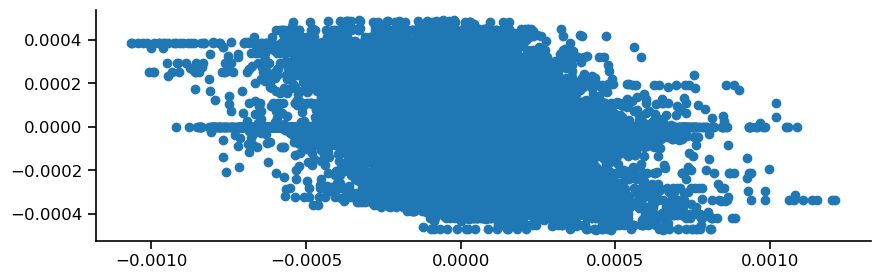

In [81]:
plt.scatter(a,b)

Computing tuning strength...
Generating plots...
W_min = -0.09823683649301529, W_max = 0.08374171704053879


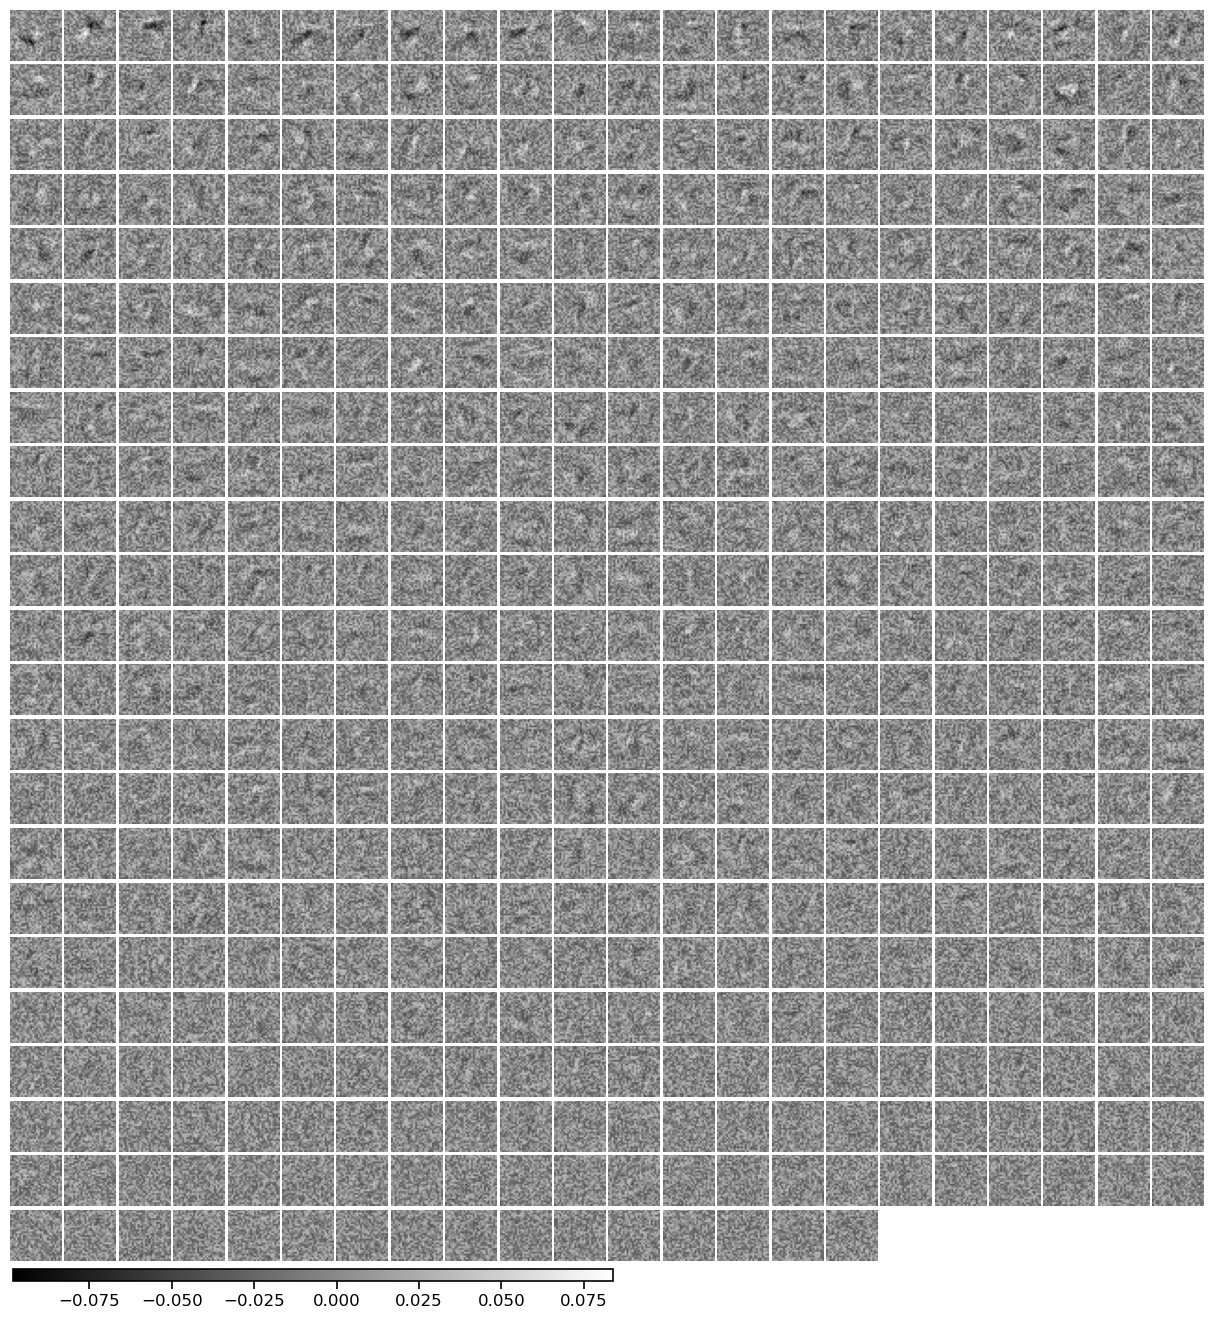

In [23]:
pt.plot_hidden_weights(bp_network.module_dict['H1E_InputE'].weight, sort=True) 

Model metrics not saved


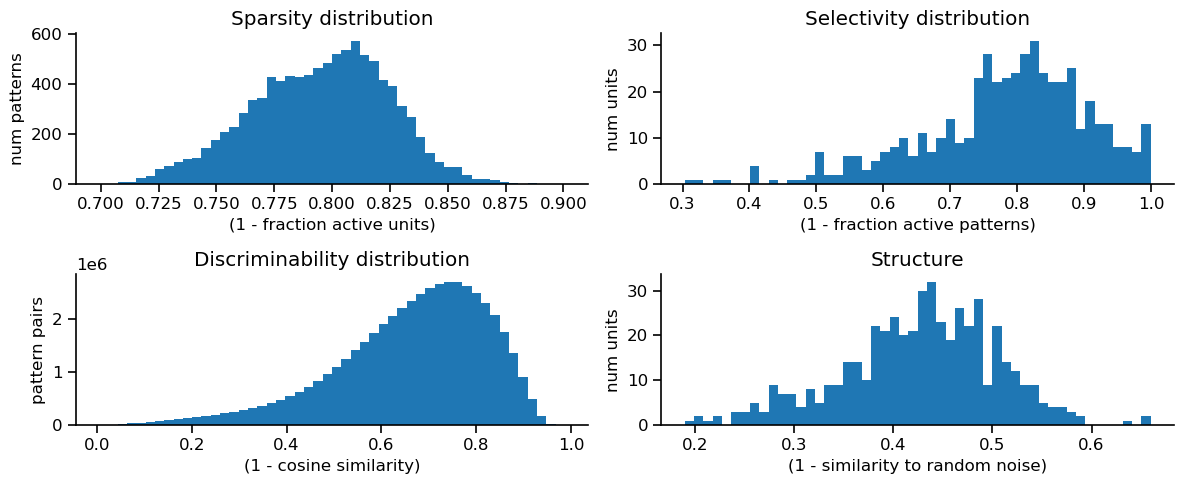

In [24]:
network = bp_network
weights = network.module_dict['H1E_InputE'].weight.detach()

# population = network.H1.E
# receptive_fields, _ = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=False)
metrics_dict = ut.compute_representation_metrics(network.H1.E, test_dataloader, receptive_fields=weights, plot=True)
metrics_dict['val_loss'] =  network.val_loss_history
metrics_dict['val_loss_steps'] = network.val_history_train_steps

ut.export_metrics_data(metrics_dict, network_name, path='saved_networks/model_metrics')

# Backprop Dale network

In [31]:
# Create network
# network_name = "EIANN_1_hidden_mnist_backprop_Dale_relu_SGD_config"
# network_config = ut.read_from_yaml(f'../config/MNIST/{network_name}.yaml')

network_name = "20230102_EIANN_1_hidden_mnist_bpDale_softplus_config.yaml"
network_config = ut.read_from_yaml(f'../optimize/data/mnist/{network_name}')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bpDale_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [32]:
# # Load pretrained network
# saved_network_path = f"saved_networks/{network_name}.pickle"
# bpDale_network.load(saved_network_path)

# pt.plot_batch_accuracy(bpDale_network, test_dataloader, population=bpDale_network.H1.E)
# pt.plot_rsm(bpDale_network,test_dataloader)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Model saved to saved_networks/20230102_EIANN_1_hidden_mnist_bpDale_softplus_config.yaml.pkl
Batch accuracy = 91.41000366210938%


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:612: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:642: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:208: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


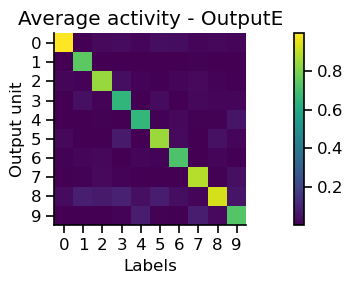

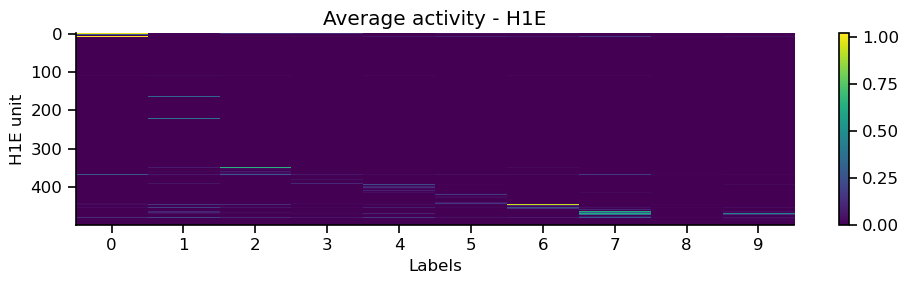

<Figure size 1000x300 with 0 Axes>

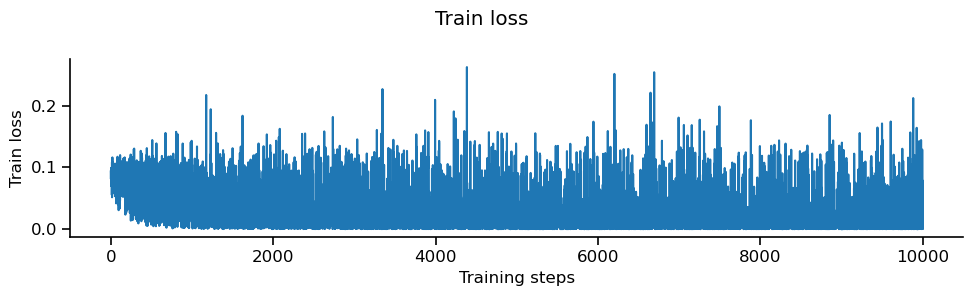

In [33]:
# Train network
data_generator.manual_seed(data_seed)
bpDale_network.train(train_sub_dataloader, 
                              test_dataloader, 
                              epochs=epochs,
                              val_interval=(0,-1,1000),
                              store_history=True, 
                              store_params=True,
                              status_bar=True)

bpDale_network.save(file_name_base=network_name)

pt.plot_batch_accuracy(bpDale_network, test_dataloader, population=bpDale_network.H1.E)
plt.figure()
pt.plot_train_loss_history(bpDale_network)
plt.show()

File already contains metrics for this model. Overwrite? (y/n)y


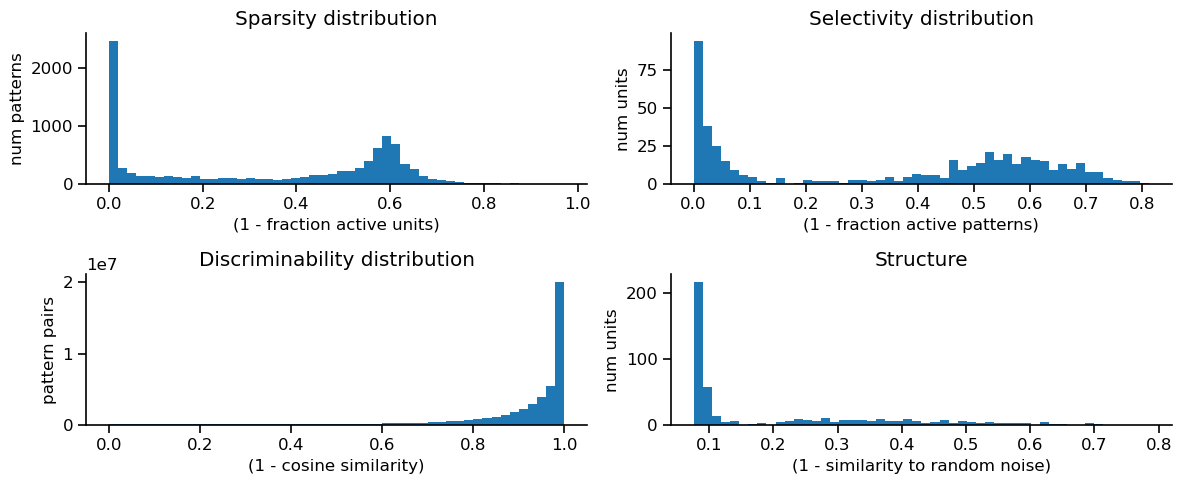

In [59]:
network = bpDale_network
weights = network.module_dict['H1E_InputE'].weight.detach()

# population = network.H1.E
# receptive_fields, _ = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=False)
metrics_dict = ut.compute_representation_metrics(network.H1.E, test_dataloader, receptive_fields=weights, plot=True)
metrics_dict['val_loss'] =  network.val_loss_history
metrics_dict['val_loss_steps'] = network.val_history_train_steps

ut.export_metrics_data(metrics_dict, network_name, path='saved_networks/model_metrics')

Computing tuning strength...
Generating plots...
W_min = 0.0, W_max = 0.19167248904705048


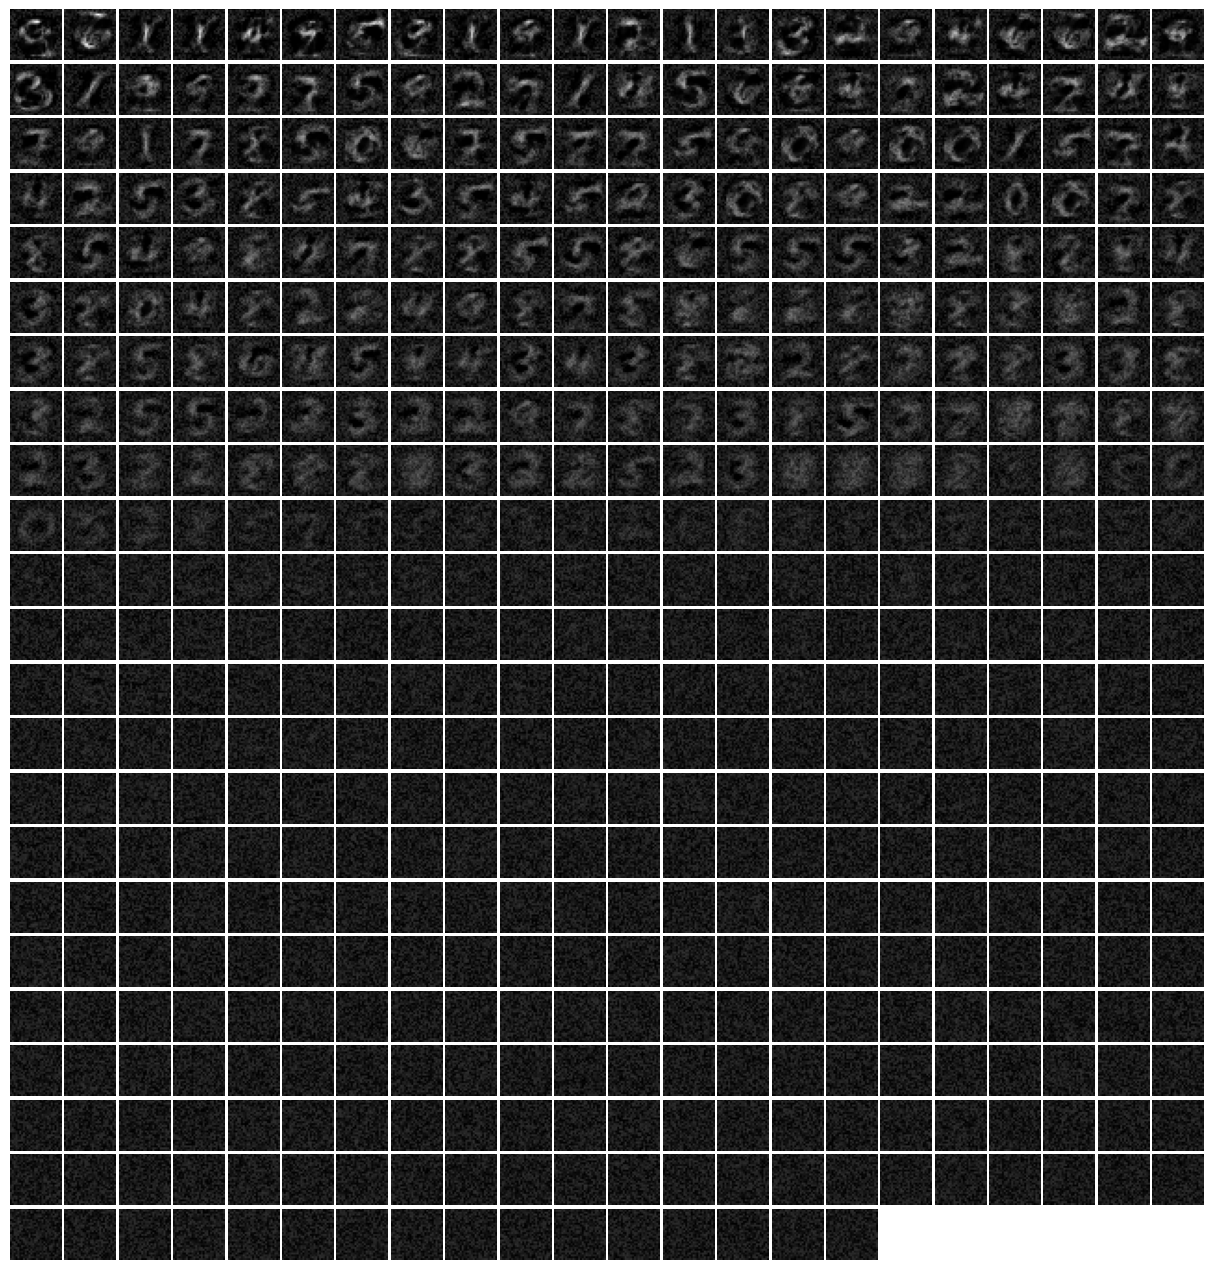

In [8]:
pt.plot_hidden_weights(bpDale_network.module_dict['H1E_InputE'].weight, sort=True)

{'sparsity': 0.3409432,
 'selectivity': 0.3409432,
 'discriminability': 0.877472,
 'structure': 0.21401237156522201}

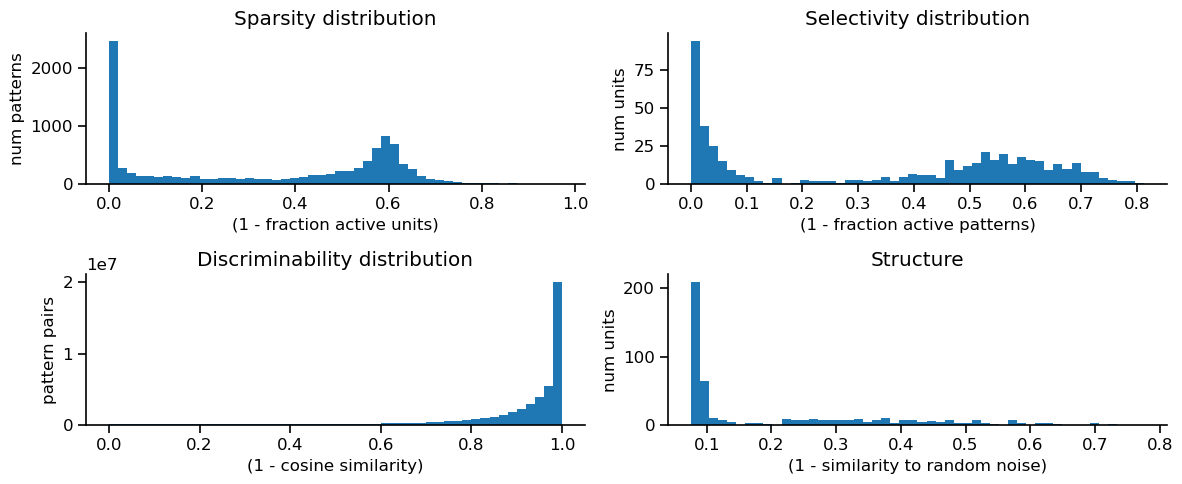

In [9]:
weights = bpDale_network.module_dict['H1E_InputE'].weight.detach()
ut.compute_representation_metrics(bpDale_network.H1.E, test_dataloader, receptive_fields=weights, plot=True)

Optimizing receptive field images...


  0%|          | 0/10000 [00:00<?, ?it/s]

Optimizing receptive field images...


  0%|          | 0/10000 [00:00<?, ?it/s]

Min activity: 1.0059486627578735, Max activity: 4.632774829864502


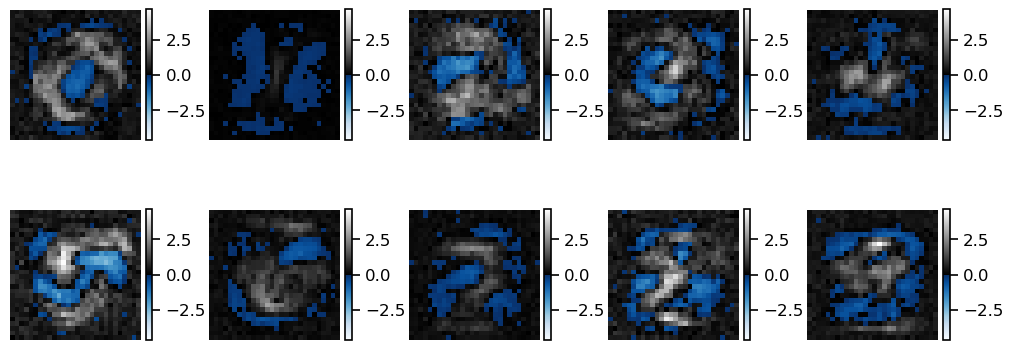

In [51]:
population = bpDale_network.Output.E
# receptive_fields, activity_preferred_inputs = ut.compute_act_weighted_avg(population, test_dataloader)
_, activity_preferred_inputs = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=True)
receptive_fields, _ = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=False)
pt.plot_receptive_fields(receptive_fields, activity_preferred_inputs)

Optimizing receptive field images...


  0%|          | 0/10000 [00:00<?, ?it/s]

Optimizing receptive field images...


  0%|          | 0/10000 [00:00<?, ?it/s]

Min activity: 5.368416786193848, Max activity: 7.825984477996826


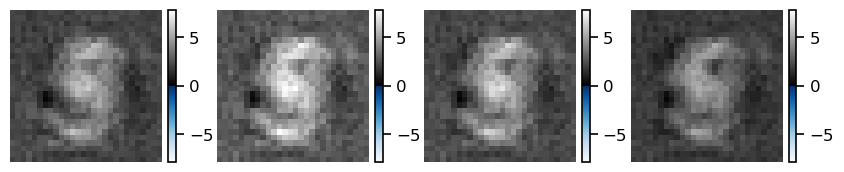

In [14]:
population = bpDale_network.Output.FBI
# receptive_fields, activity_preferred_inputs = ut.compute_act_weighted_avg(population, test_dataloader)
_, activity_preferred_inputs = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=True)
receptive_fields, _ = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=False)
pt.plot_receptive_fields(receptive_fields, activity_preferred_inputs)

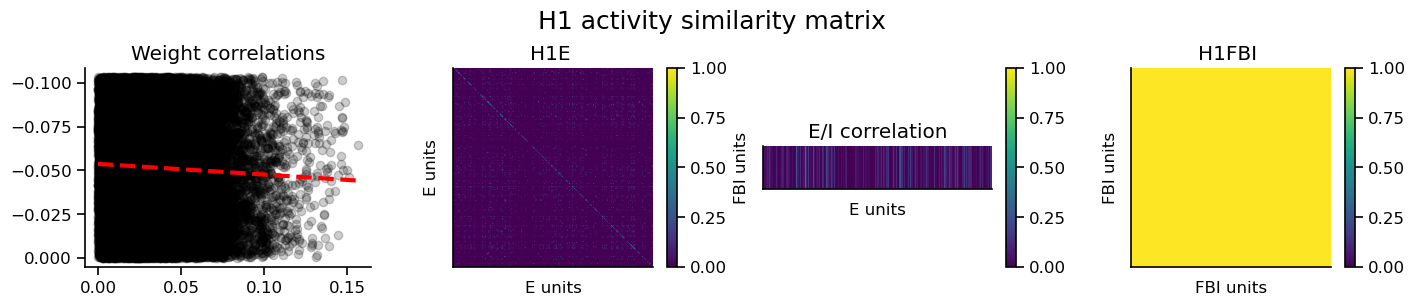

Pearson correlation: r=0.043, r^2=0.002, p=1.72E-20


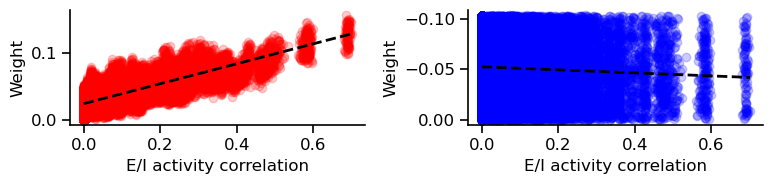

Pearson correlation (E): r=0.730, r^2=0.533, p=0.00E+00
Pearson correlation (I): r=0.052, r^2=0.003, p=3.82E-29


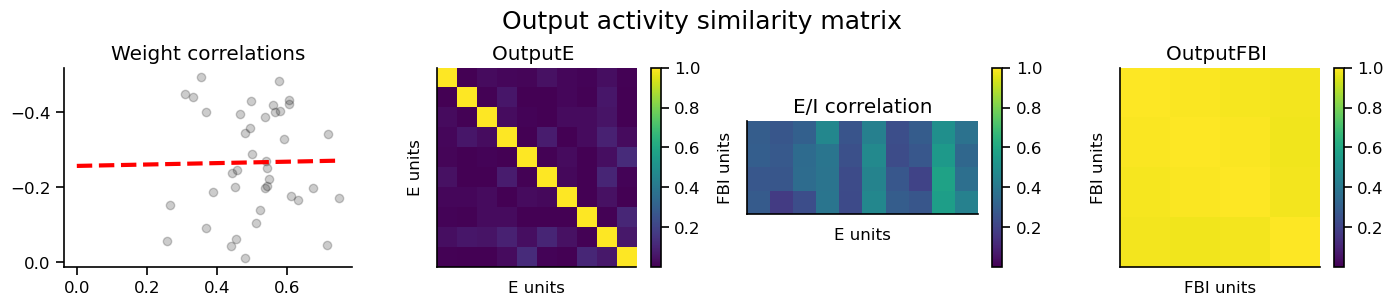

Pearson correlation: r=-0.016, r^2=0.000, p=9.23E-01


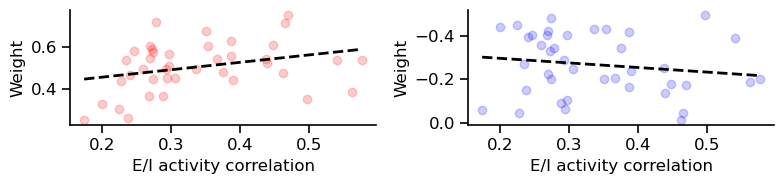

Pearson correlation (E): r=0.309, r^2=0.095, p=5.25E-02
Pearson correlation (I): r=0.157, r^2=0.025, p=3.33E-01


In [12]:
pt.plot_correlations(bpDale_network, test_dataloader)

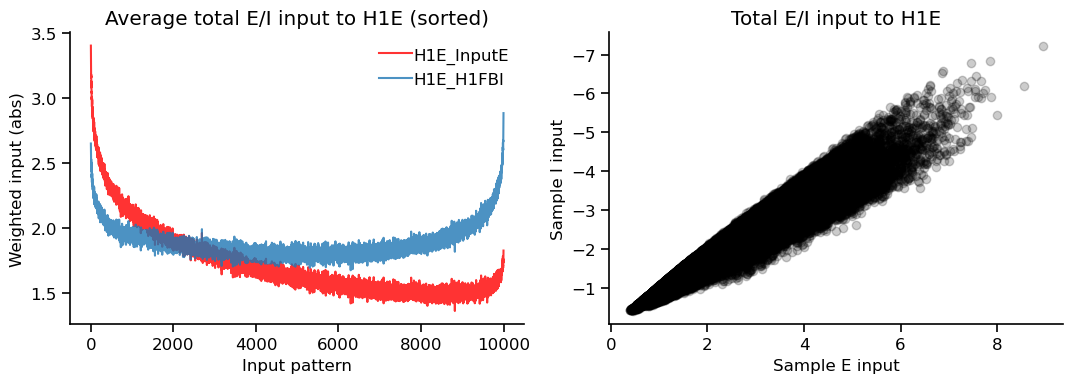

In [389]:
pt.plot_total_input(bpDale_network.H1.E, test_dataloader, sorting='EI_balance', act_threshold=0)

# Gjorgjieva Hebb network

In [35]:
# Create network
# network_name = "20230103_EIANN_1_hidden_mnist_Gjorgjieva_Hebb_config_B"
# network_config = ut.read_from_yaml('../optimize/data/20221229_EIANN_1_hidden_mnist_Gjorgjieva_Hebb_config.yaml')
# network_config = ut.read_from_yaml('../config/MNIST/EIANN_0_hidden_mnist_Gjorgjieva_Hebb_config.yaml')
# network_config = ut.read_from_yaml(f'../optimize/data/{network_name}.yaml')

network_name = '20230214_1_hidden_mnist_Supervised_Gjorgjieva_Hebb_C.yaml'
network_config = ut.read_from_yaml(f'../optimize/data/mnist/{network_name}')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

gj_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [36]:
# # Load pretrained network
# saved_network_path = f"saved_networks/{network_name}.pickle"
# gj_network.load(saved_network_path)

# pt.plot_batch_accuracy(gj_network, test_dataloader, population=gj_network.H1.E)
# pt.plot_rsm(gj_network,test_dataloader)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Model saved to saved_networks/20230214_1_hidden_mnist_Supervised_Gjorgjieva_Hebb_C.yaml.pkl
Batch accuracy = 69.94000244140625%


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:612: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:642: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:208: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


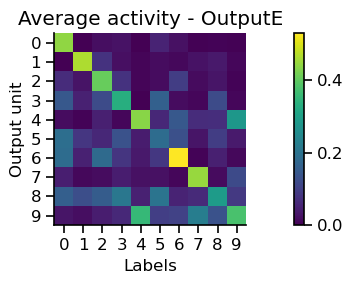

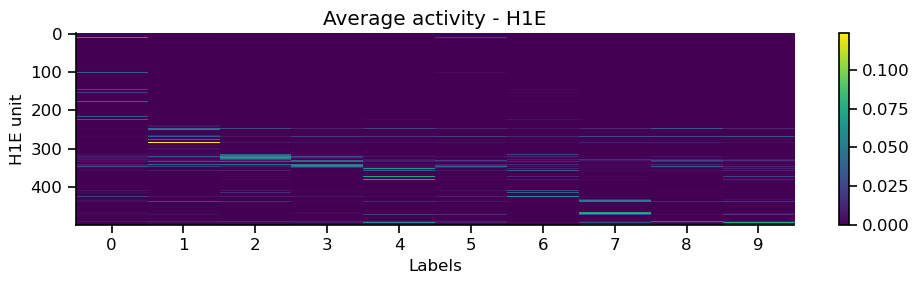

<Figure size 1000x300 with 0 Axes>

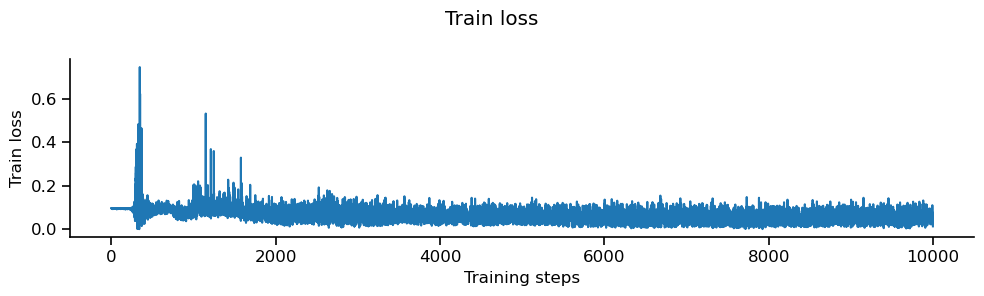

In [37]:
# Train network
data_generator.manual_seed(data_seed)
gj_network.train(train_sub_dataloader, 
                              test_dataloader, 
                              epochs=epochs,
                              val_interval=(0,-1,1000),
                              store_history=True, 
                              store_params=False, 
                              status_bar=True)

gj_network.save(file_name_base=network_name)

pt.plot_batch_accuracy(gj_network, test_dataloader, population=gj_network.H1.E)
plt.figure()
pt.plot_train_loss_history(gj_network)
plt.show()

File already contains metrics for this model. Overwrite? (y/n)y


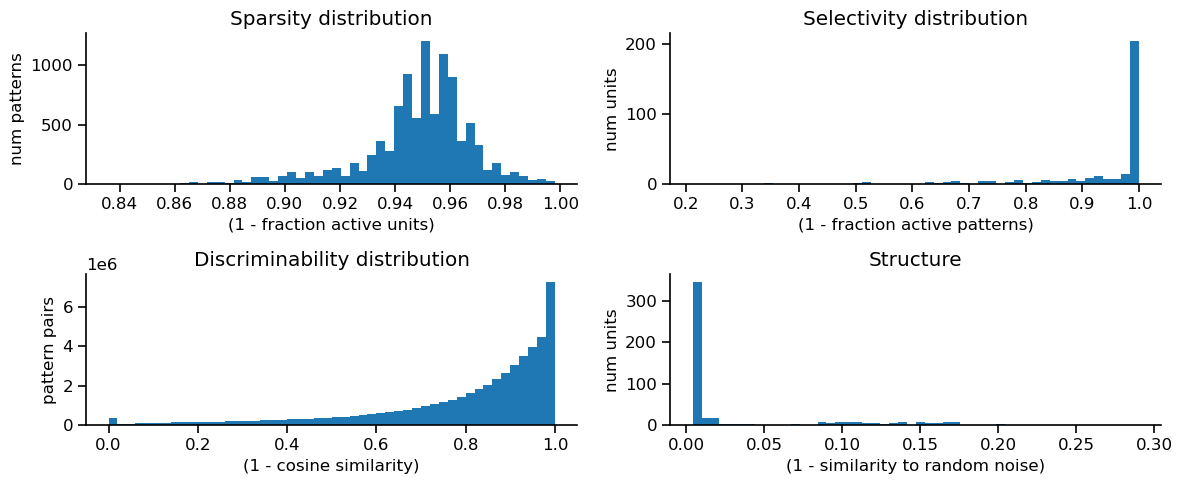

In [60]:
network = gj_network
weights = network.module_dict['H1E_InputE'].weight.detach()

# population = network.H1.E
# receptive_fields, _ = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=False)
metrics_dict = ut.compute_representation_metrics(network.H1.E, test_dataloader, receptive_fields=weights, plot=True)
metrics_dict['val_loss'] =  network.val_loss_history
metrics_dict['val_loss_steps'] = network.val_history_train_steps

ut.export_metrics_data(metrics_dict, network_name, path='saved_networks/model_metrics')

Computing tuning strength...
Generating plots...
W_min = 1.679862195527737e-12, W_max = 0.03245251625776291


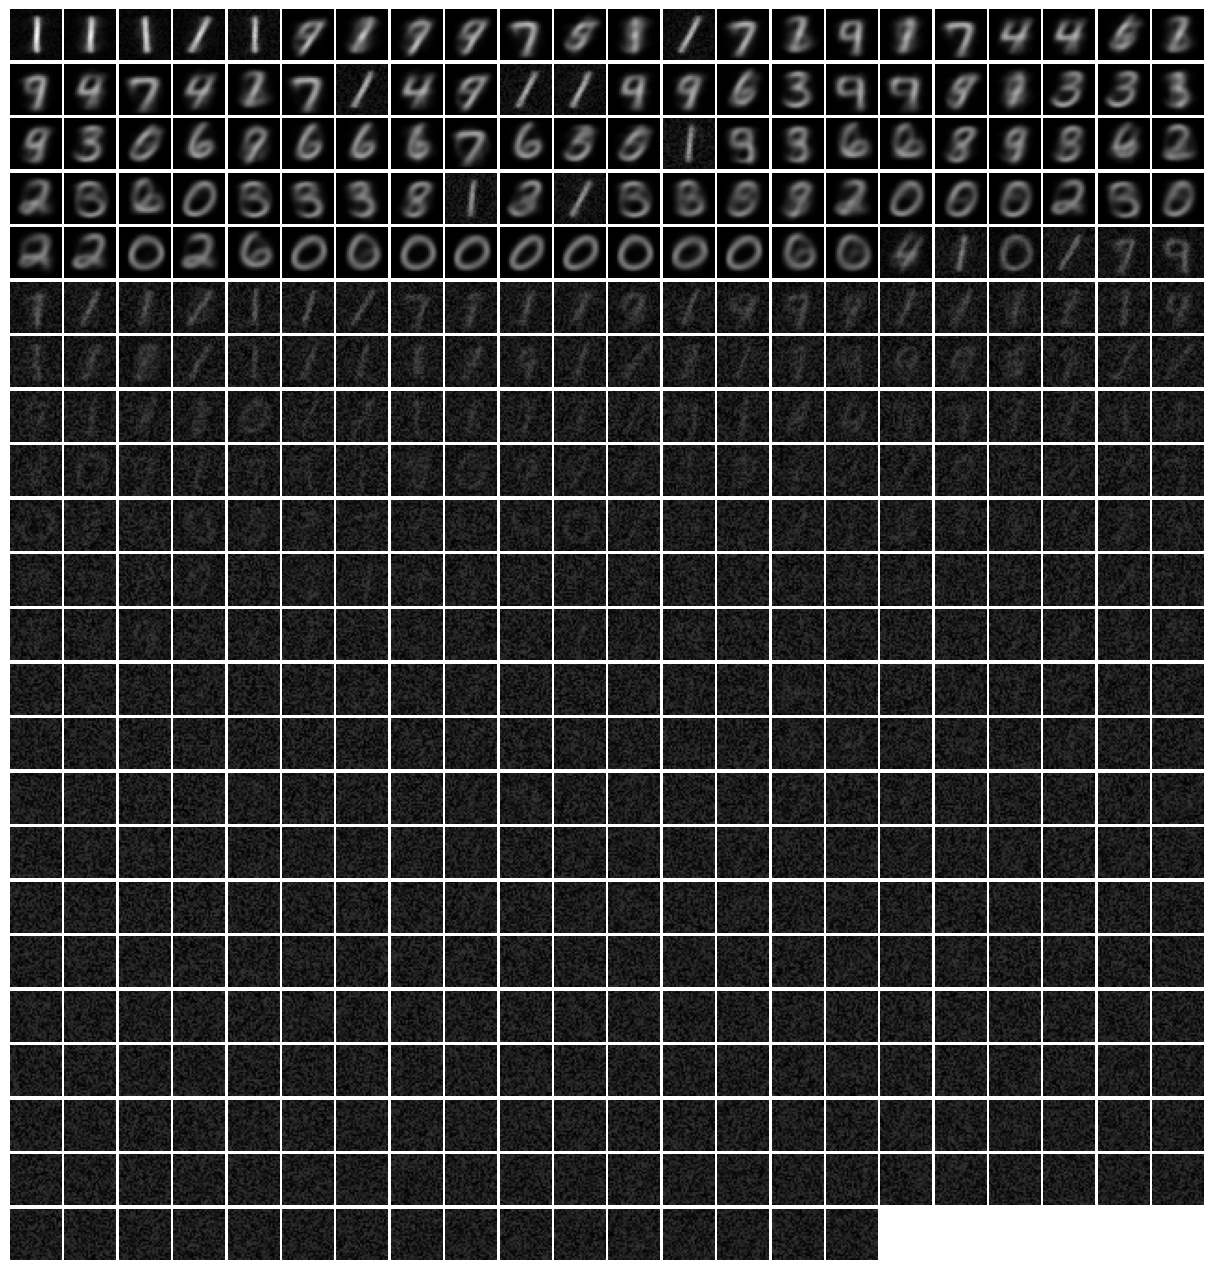

In [263]:
pt.plot_hidden_weights(gj_network.module_dict['H1E_InputE'].weight, sort=True)

Optimizing receptive field images...


  0%|          | 0/10000 [00:00<?, ?it/s]

Min activity: 0.16501730680465698, Max activity: 0.424085795879364


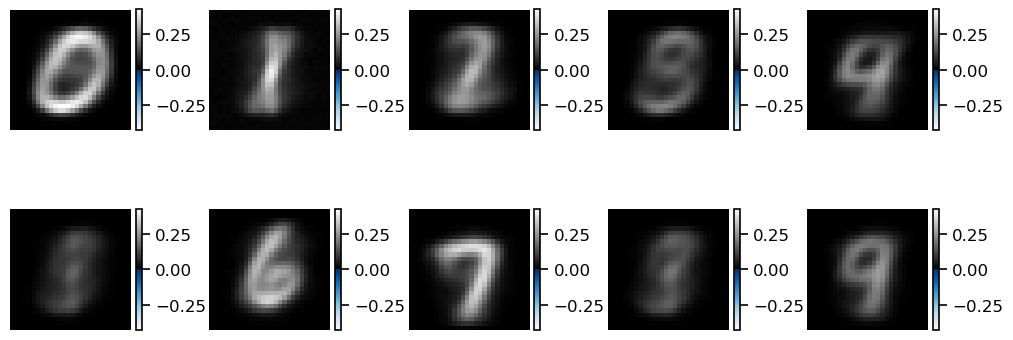

In [265]:
population = gj_network.Output.E
# receptive_fields, activity_preferred_inputs = ut.compute_act_weighted_avg(population, test_dataloader)
# _, activity_preferred_inputs = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=True)
receptive_fields, activity_preferred_inputs = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=False)
pt.plot_receptive_fields(receptive_fields, activity_preferred_inputs)

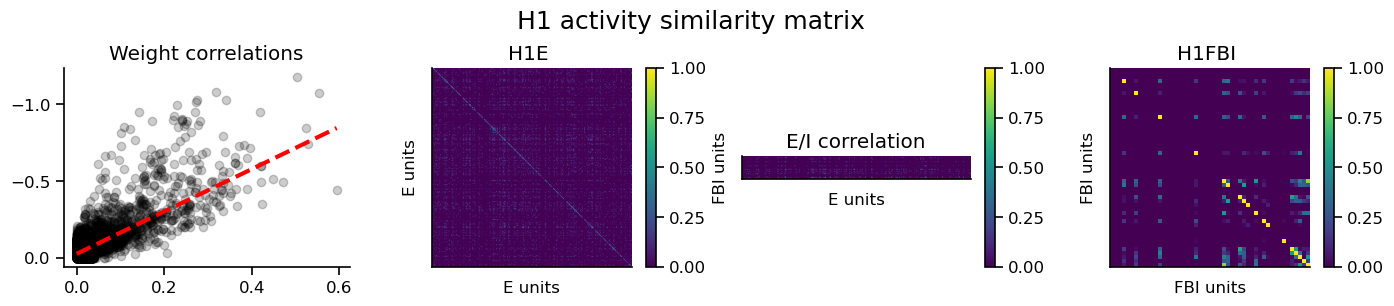

Pearson correlation: r=-0.643, r^2=0.413, p=0.00E+00


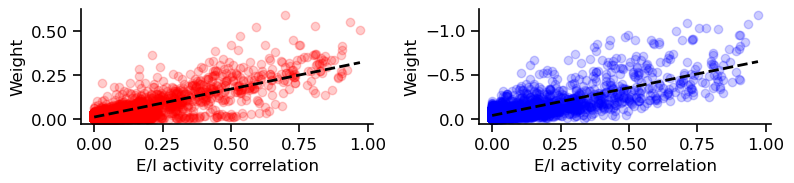

Pearson correlation (E): r=0.794, r^2=0.630, p=0.00E+00
Pearson correlation (I): r=-0.728, r^2=0.530, p=0.00E+00


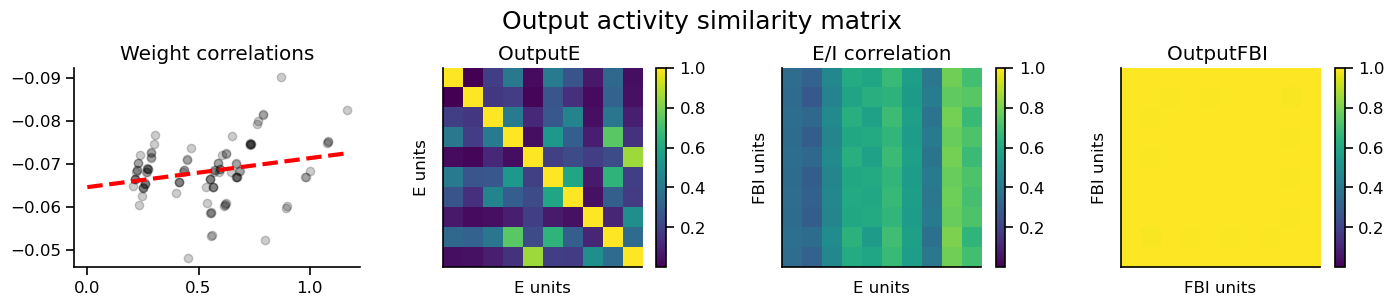

Pearson correlation: r=-0.248, r^2=0.061, p=1.29E-02


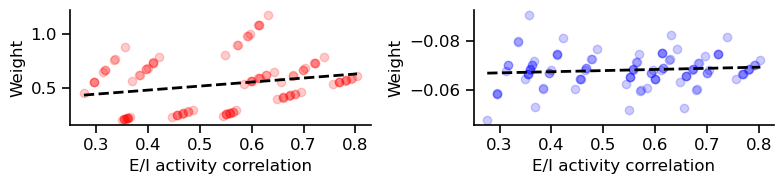

Pearson correlation (E): r=0.232, r^2=0.054, p=2.01E-02
Pearson correlation (I): r=-0.106, r^2=0.011, p=2.96E-01


In [266]:
pt.plot_correlations(gj_network, test_dataloader)

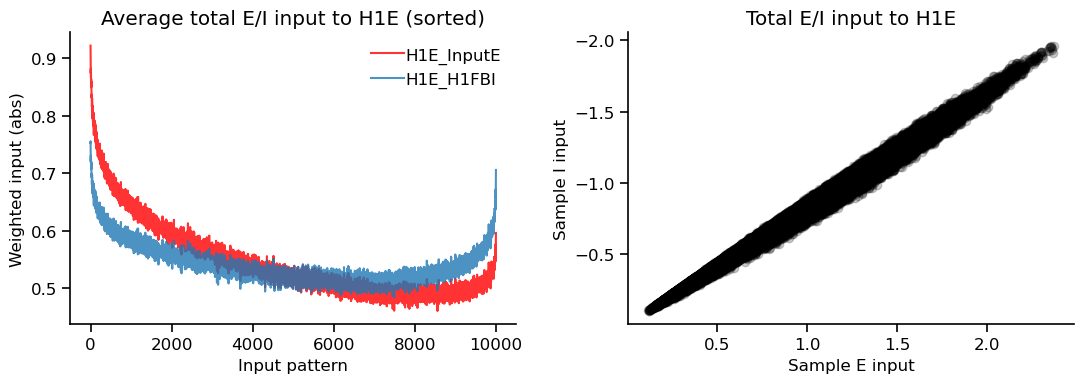

In [398]:
pt.plot_total_input(gj_network.H1.E, test_dataloader, sorting='EI_balance', act_threshold=0)

# BTSP network

In [263]:
# Create network
# network_name = "20230104_EIANN_1_hidden_mnist_BTSP_config_F"
# network_config = ut.read_from_yaml(f'../optimize/data/{network_name}.yaml')

network_name = 'EIANN_1_hidden_mnist_BTSP_config.yaml'
network_config = ut.read_from_yaml(f'../config/MNIST_templates/{network_name}')

# network_name = '20230214_1_hidden_mnist_BTSP_Clone_Dend_I_1_bad.yaml'
# network_name = '20230220_1_hidden_mnist_BTSP_Clone_Dend_I_4.yaml'
# network_config = ut.read_from_yaml(f'../optimize/data/mnist/{network_name}')

# network_name = 'EIANN_1_hidden_mnist_BTSP_CloneDend.yaml'
# network_config = ut.read_from_yaml(f'../config/MNIST/{network_name}')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [8]:
# # Load pretrained network
# saved_network_path = f"saved_networks/{network_name}.pkl"
# # saved_network_path = f"saved_networks/{network_name}.pickle"
# # saved_network_path = f"saved_networks/{network_name}_early.pickle"

# btsp_network.load(saved_network_path)

# pt.plot_batch_accuracy(btsp_network, test_dataloader, population=btsp_network.H1.E)
# pt.plot_rsm(btsp_network,test_dataloader)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Batch accuracy = 85.62999725341797%


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:612: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:642: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:208: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


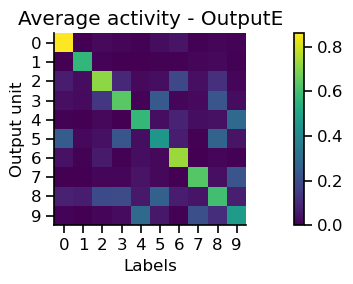

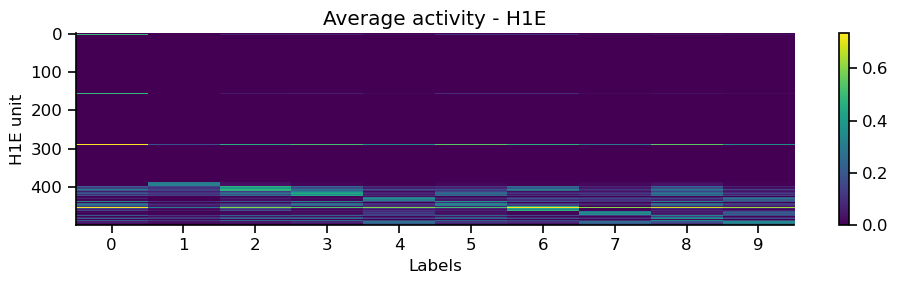

<Figure size 1000x300 with 0 Axes>

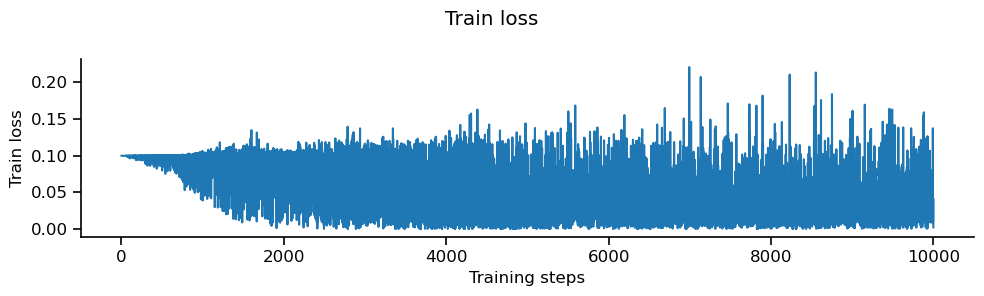

/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:669: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(0, num_labels))
/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:670: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(0, num_labels))


Model saved to saved_networks/20230220_1_hidden_mnist_BTSP_Clone_Dend_I_4.yaml.pkl


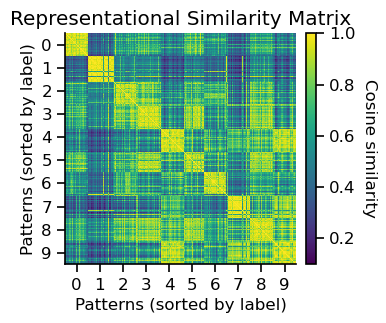

In [9]:
# Train network
data_generator.manual_seed(data_seed)
btsp_network.train(train_sub_dataloader, 
                                test_dataloader, 
                                epochs=epochs,
                                val_interval=(0,-1,1000),
                                store_history=True, 
                                store_params=False, 
                                status_bar=True)

pt.plot_batch_accuracy(btsp_network, test_dataloader, population=btsp_network.H1.E)
plt.figure()
pt.plot_train_loss_history(btsp_network)
plt.show()
pt.plot_rsm(btsp_network,test_dataloader)

btsp_network.save(file_name_base=network_name)

Computing tuning strength...
Generating plots...
W_min = 1.5967402955396892e-09, W_max = 0.03222929313778877


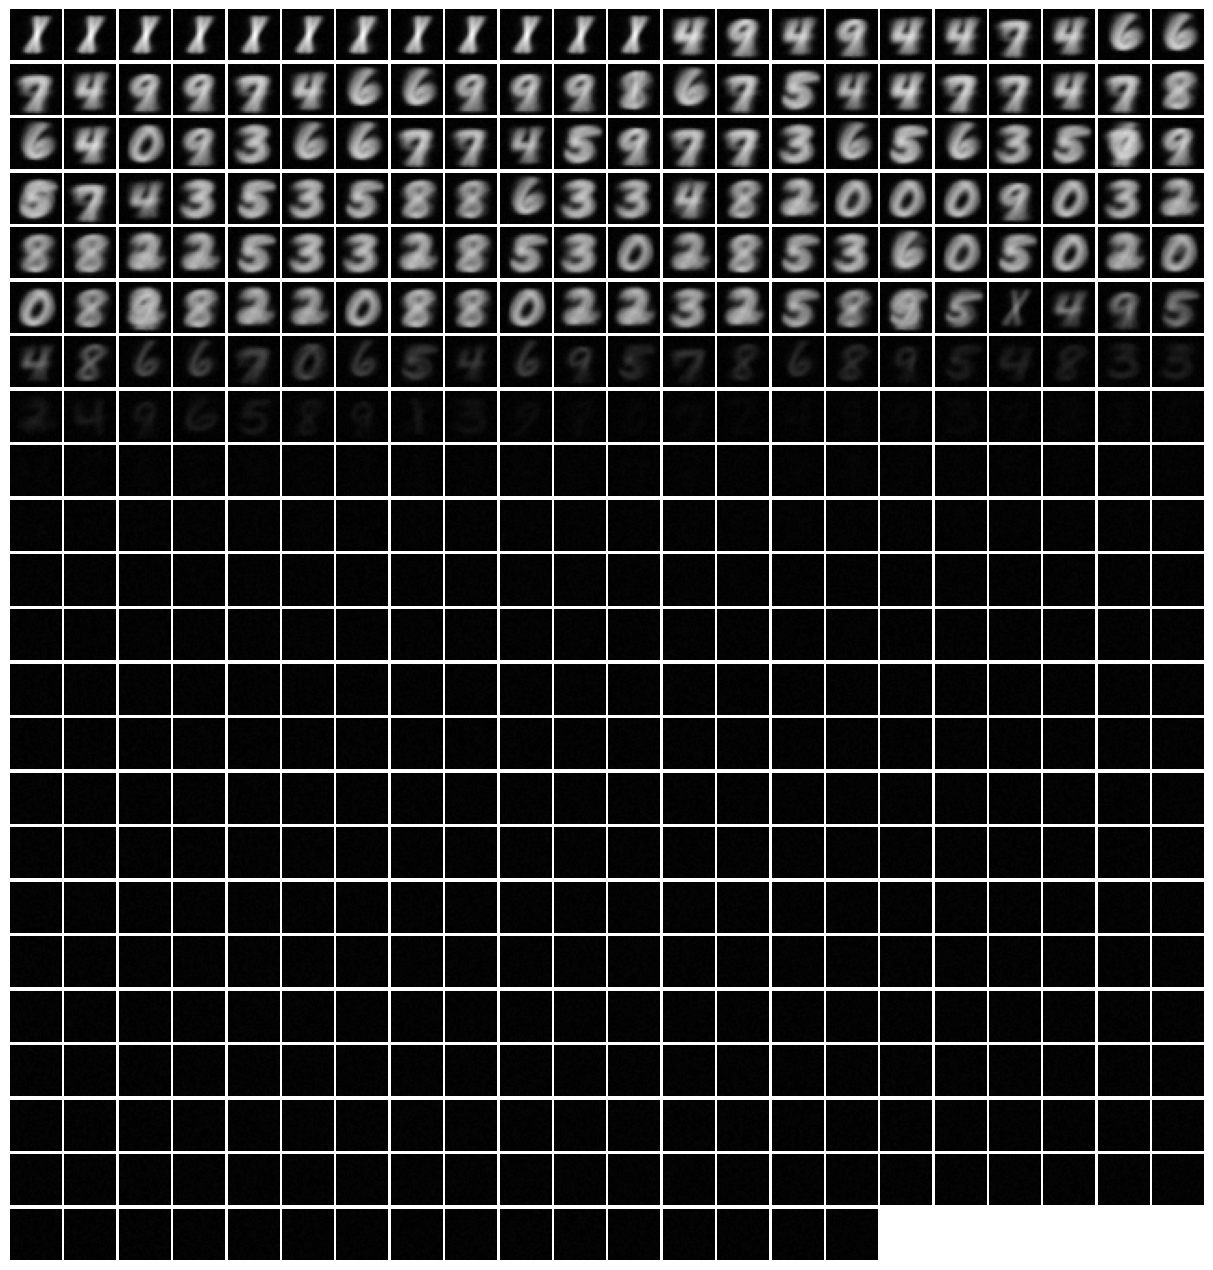

In [10]:
pt.plot_hidden_weights(btsp_network.module_dict['H1E_InputE'].weight, sort=True)

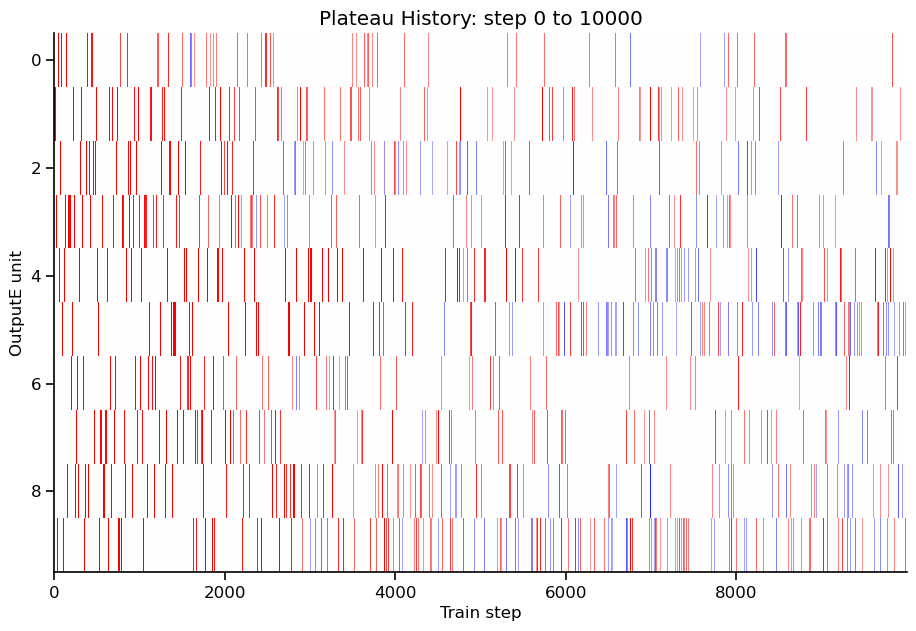

In [11]:
pt.plot_plateaus(population=btsp_network.Output.E, start=0, end=10000)

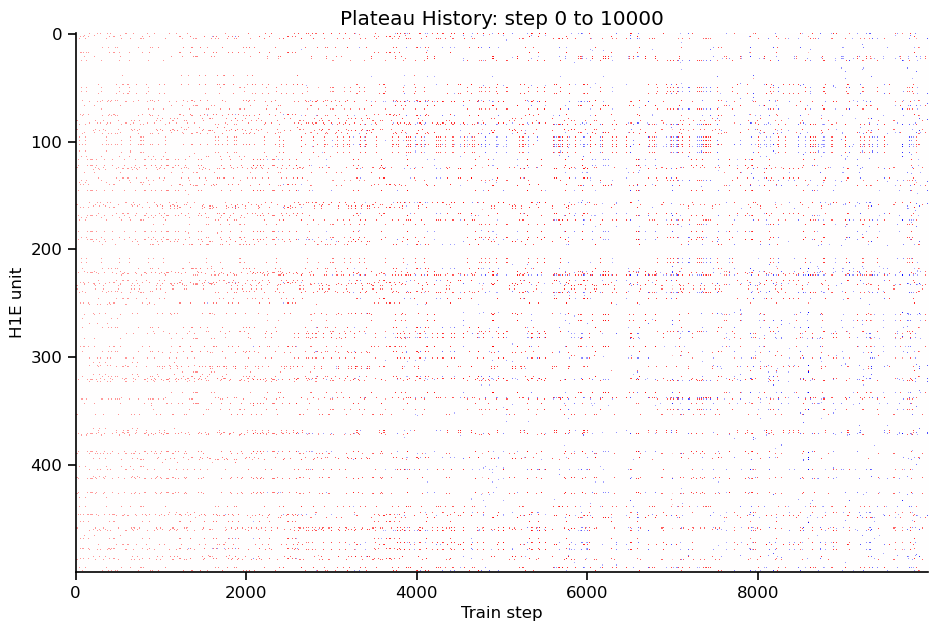

In [12]:
pt.plot_plateaus(population=btsp_network.H1.E, start=0, end=10000)

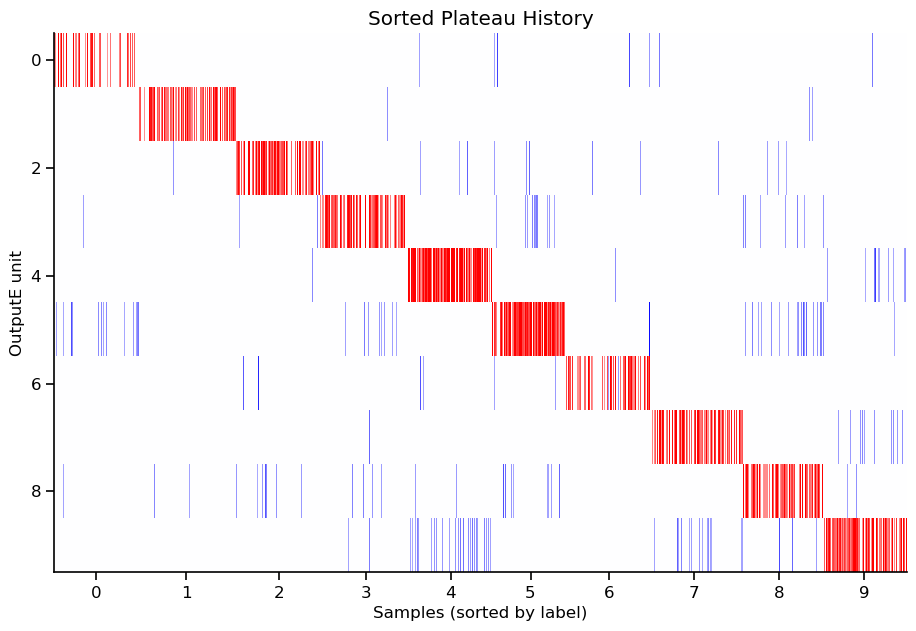

In [13]:
sorted_plateaus, unit_ids = pt.plot_sorted_plateaus(btsp_network.Output.E, test_dataloader)

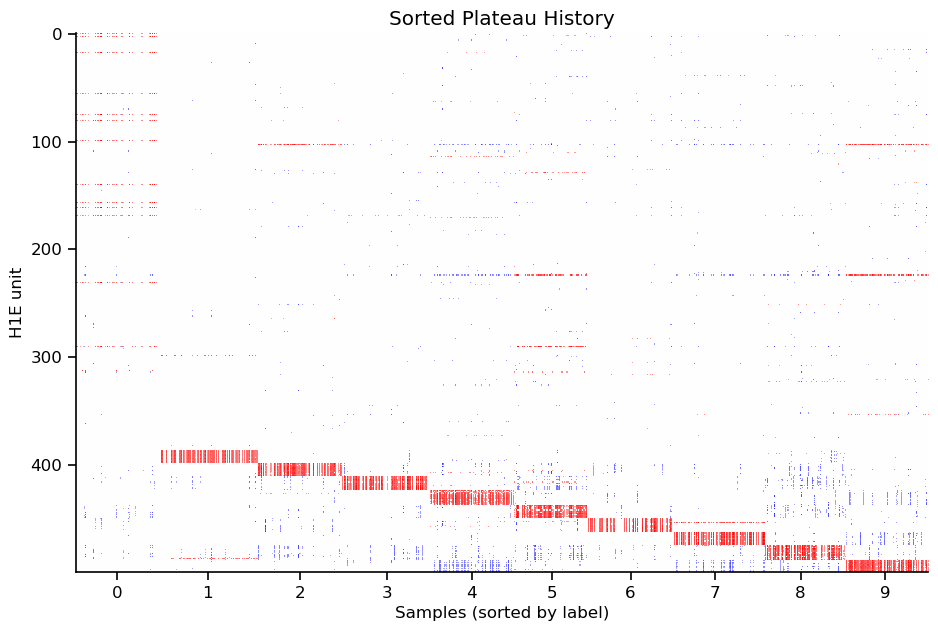

In [14]:
sorted_plateaus, unit_ids = pt.plot_sorted_plateaus(btsp_network.H1.E, test_dataloader)

File already contains metrics for this model. Overwrite? (y/n)y


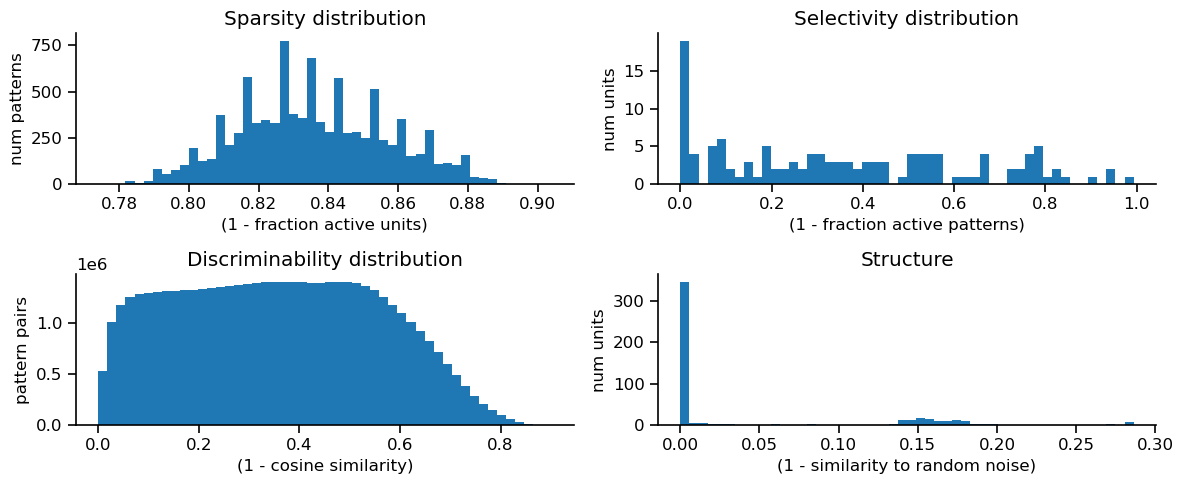

In [61]:
network = btsp_network
weights = network.module_dict['H1E_InputE'].weight.detach()

# population = network.H1.E
# receptive_fields, _ = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=False)
metrics_dict = ut.compute_representation_metrics(network.H1.E, test_dataloader, receptive_fields=weights, plot=True)
metrics_dict['val_loss'] =  network.val_loss_history
metrics_dict['val_loss_steps'] = network.val_history_train_steps

ut.export_metrics_data(metrics_dict, network_name, path='saved_networks/model_metrics')

In [147]:
# pt.plot_hidden_weight_history(btsp_network, unit=368)

Optimizing receptive field images...


  0%|          | 0/10000 [00:00<?, ?it/s]

Min activity: 0.48158198595046997, Max activity: 0.9709281921386719


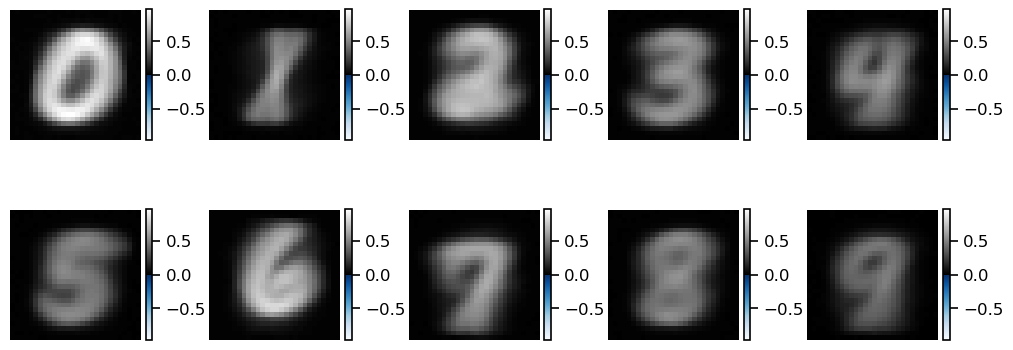

In [15]:
population = btsp_network.Output.E
_, activity_preferred_inputs = ut.compute_act_weighted_avg(population, test_dataloader)
# _, activity_preferred_inputs = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=True)
receptive_fields, _ = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=False)
pt.plot_receptive_fields(receptive_fields, activity_preferred_inputs)

/var/folders/q9/g15z8pxs2fd8tgyd9ggfv1c8x5w4qx/T/ipykernel_47104/279513344.py:1: RankWarning: Polyfit may be poorly conditioned
  pt.plot_correlations(btsp_network, test_dataloader)
/Users/ag1880/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


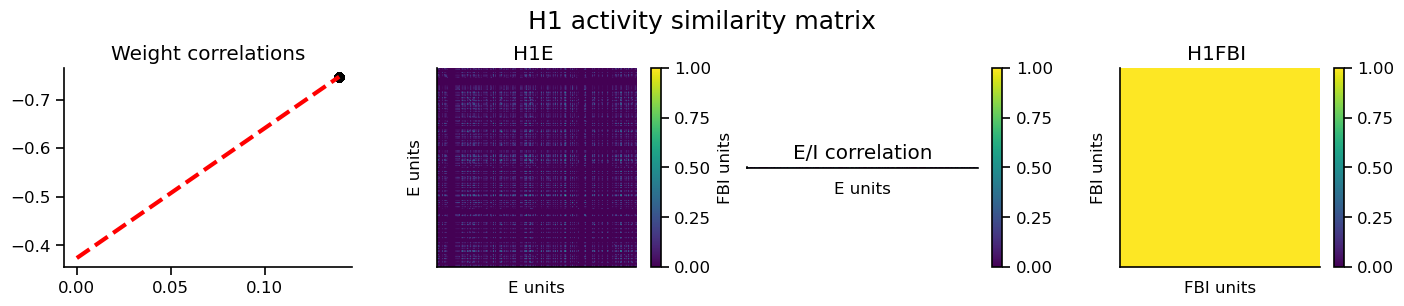

Pearson correlation: r=nan, r^2=nan, p=NAN


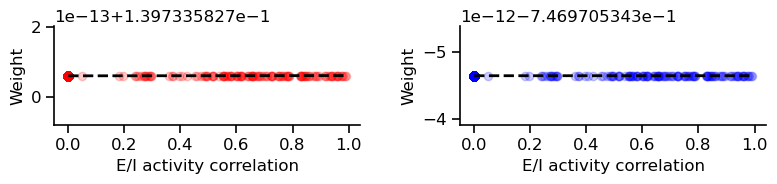

Pearson correlation (E): r=nan, r^2=nan, p=NAN
Pearson correlation (I): r=nan, r^2=nan, p=NAN


/var/folders/q9/g15z8pxs2fd8tgyd9ggfv1c8x5w4qx/T/ipykernel_47104/279513344.py:1: RankWarning: Polyfit may be poorly conditioned
  pt.plot_correlations(btsp_network, test_dataloader)
/Users/ag1880/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


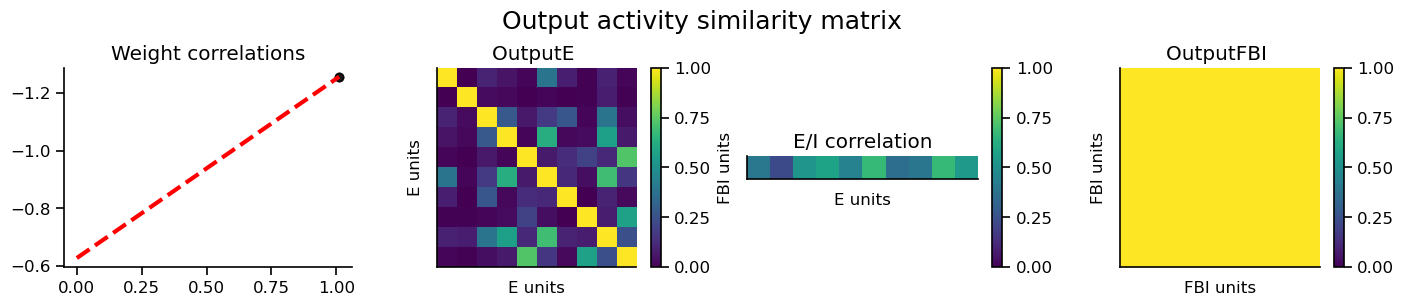

Pearson correlation: r=nan, r^2=nan, p=NAN


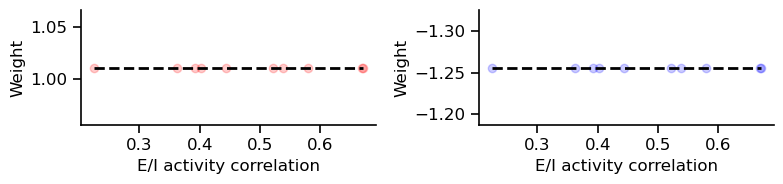

Pearson correlation (E): r=nan, r^2=nan, p=NAN
Pearson correlation (I): r=nan, r^2=nan, p=NAN


In [16]:
pt.plot_correlations(btsp_network, test_dataloader)

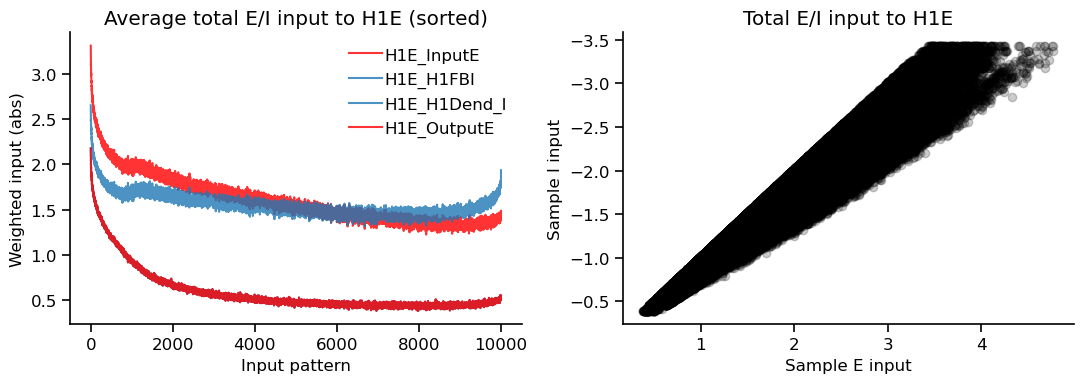

In [17]:
pt.plot_total_input(btsp_network.H1.E, test_dataloader, sorting='EI_balance', act_threshold=0)